Date Created: 10/23/20
## Goal of Notebook: Function Pham Bipartite Projections
Project the pham and function graphs using the function bipartite graph created in "09-25 Pham v. Function". This notebook attempts to further invesitgate if pham is a subset of function

In [3]:
import requests 
import pandas as pd
from random import sample 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns                                                             
import sys 
from networkx.algorithms import bipartite


In [4]:
df_phages = pd.read_csv("data/phage_metadata.csv")
df_phages.head()

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
0,20ES,True,A,A2,SIPHO,Mycobacterium,smegmatis,53124.0,False,True,63.4
1,244,True,E,NaN,SIPHO,Mycobacterium,smegmatis,74483.0,True,True,63.4
2,32HC,True,Z,NaN,SIPHO,Mycobacterium,smegmatis,50781.0,False,True,65.7
3,39HC,False,B,B6,SIPHO,Mycobacterium,smegmatis,71565.0,False,True,70.0
4,40AC,True,A,A17,SIPHO,Mycobacterium,smegmatis,53396.0,False,True,63.3


In [5]:
df_genes = pd.read_csv("data/cleaned_gene_list.csv")
df_genes.head()

,gene ID,pham,function,translation,orientation,phage,gene number,uncleaned function
0,20ES_CDS_1,36676,NKF,MYGTRSSAFWASQPGKFDVLNLRMTFPSTSAHEIPDLTATDFVPEN...,F,20ES,1,NaN
1,20ES_CDS_10,39578,lysin b,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,F,20ES,10,lysin b
2,20ES_CDS_11,34196,terminase,MSLENHHPELAPSPPHIIGPSWQRTVDGSWHLPDPKMTLGWGVLKW...,F,20ES,11,terminase
3,20ES_CDS_12,39511,portal protein,MTAPLPGQEEIPDPAIARDEMISAFDDAVKNLKINTSYYEAERRPE...,F,20ES,12,portal protein
4,20ES_CDS_13,21454,capsid maturation protease,MITAAVAAYVQRFASMFTGPALSLGEWARFLQTLFPEVQRRYAQAA...,F,20ES,13,capsid maturation protease


In [9]:
df_annotated_phages = df_phages[df_phages["is annotated"]==True]
df_annotated_phages.head()

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
1,244,True,E,NaN,SIPHO,Mycobacterium,smegmatis,74483.0,True,True,63.4
6,Aaronocolus,True,BD,BD1,NaN,Streptomyces,griseus,49562.0,True,True,66.2
8,AbbeyMikolon,True,BL,NaN,SIPHO,Streptomyces,lividans,42551.0,True,True,66.8
11,ABCat,True,E,NaN,SIPHO,Mycobacterium,smegmatis,76131.0,True,True,63.0
12,Abdiel,True,A,A4,SIPHO,Mycobacterium,smegmatis,51381.0,True,True,63.9


In [5]:
df_annotated_genes = df_genes[df_genes['phage'].isin(list(df_annotated_phages["phage"]))]
df_annotated_genes.head()

,gene ID,pham,function,translation,orientation,phage,gene number,uncleaned function
96,244_CDS_1,20545,NKF,MCPTWGNGAYALHIYAPRGTPITEYHALPAWKLALTCTHPYAMQQT...,F,244,1,NaN
97,244_CDS_10,17677,NKF,MFEKKDLLKDHVRERFYVTPGHDVPPFTGILLNVAKANLEFGDVRV...,F,244,10,NaN
98,244_CDS_100,39422,NKF,MHRRKTSARLCERPECGQKSRGKRLCSKHLQREKAGIQSDDQLQYH...,F,244,100,NaN
99,244_CDS_101,39453,NKF,MSKDLQVHLVGTLTADPELRFTQGGQAVANFTVVSNERRRDAQGNW...,F,244,101,NaN
100,244_CDS_102,38742,NKF,MLPLRKLFRGGKPSFEQIMAPSEQGSTLTAPTPMSPALEEATIAKL...,F,244,102,NaN


In [6]:
len(df_phages["phage"])

3228

Classifying all NFK genes into one chunk takes away from what value they have to the genome that we do not know

Options:
-Assign them function 
-Assign them by pham

Create Bipartite Network pham-function

In [7]:
# taken from "PhagesDB Pham V. Function Analysis"
G = nx.Graph()
for index, row in df_annotated_genes.sort_values(by='phage').iterrows():
    function = row['function']
    pham = row['pham']
    phage= row['phage']

    # ADD PHAM NODE if it doesn't exist
    if not G.has_node(pham):
        G.add_node(pham, group='pham', phages=[phage], freq = 1)
    else:
        G.nodes[pham]["freq"] += 1
        G.nodes[pham]["phages"].append(phage)
        
    # ADD FUNCTION NODE if it doesn't exist
    if not G.has_node(function):
        G.add_node(function, group='function', phages=[phage], freq = 1)
    else:
        G.nodes[function]["freq"] += 1
        G.nodes[function]["phages"].append(phage)
            
    # ADD EDGE if it doesn't exist or increase weight     
    if G.has_edge(pham, function):
        G.edges[pham, function]["weight"] += 1  
    else:
        G.add_edge(pham, function, weight = 1)

Summary Stats for bipartite graph

In [8]:
print("# Edges", G.size())
print("# Nodes", len(G.nodes()))

# Edges 9547
# Nodes 8537


Group the pham and function nodes for projections

In [9]:
function_nodes = []
pham_nodes = []

for i in G.nodes():
    if G.nodes[i]["group"] == 'pham':
        pham_nodes.append(i)
    elif G.nodes[i]["group"] == 'function':
        function_nodes.append(i)

## Pham and Function Projections

In [23]:
G_function = bipartite.projected_graph(G, function_nodes)
G_function.remove_node("NKF")
print("Function Projection")
print("# Edges", G_function.size())
print("# Nodes", len(G_function.nodes()))

Function Projection
# Edges 223
# Nodes 167


In [24]:
G_pham = bipartite.projected_graph(G, pham_nodes)
print("Pham Projection")
print("# Edges", G_pham.size())
print("# Nodes", len(G_pham.nodes()))

Pham Projection
# Edges 28376991
# Nodes 8369


Visualization of function projection shows a lot of connectivity. Leading me to believe that pham is not a subset of function.

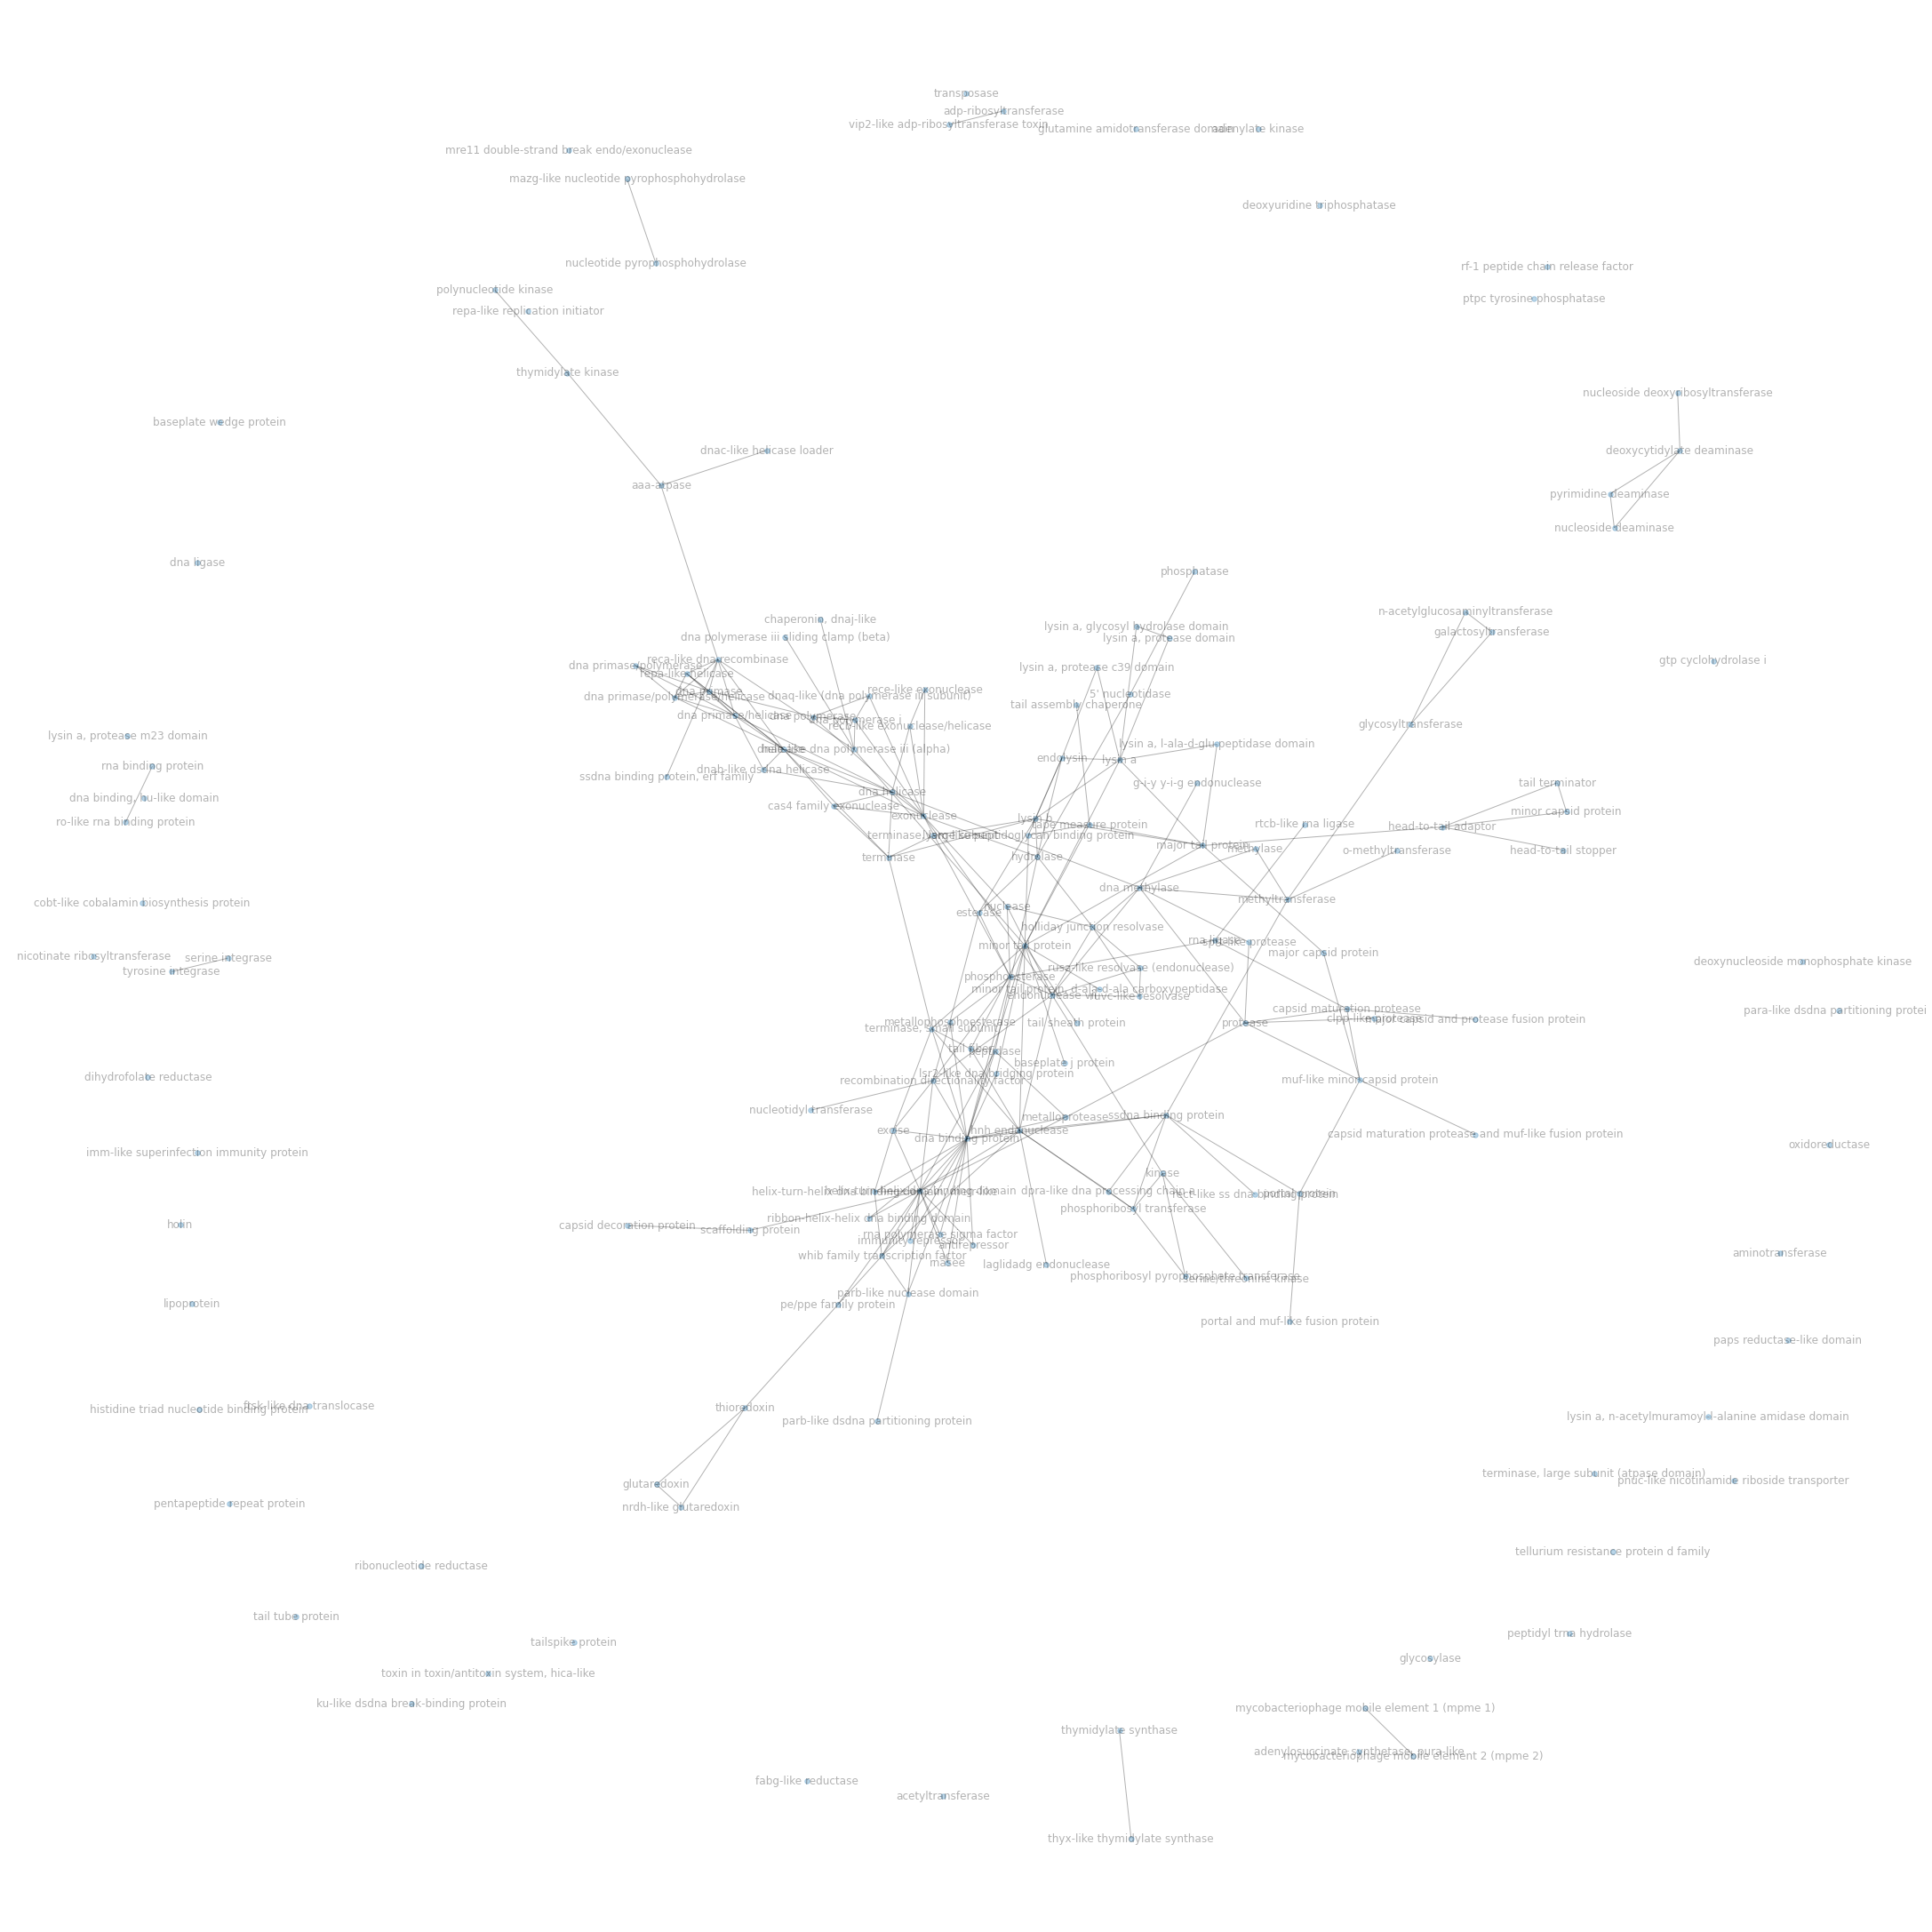

In [25]:
plt.figure(figsize=(30,30))
nx.draw(G_function, pos = nx.spring_layout(G_function, k=0.15), with_labels = True, node_size = 30, alpha= 0.3)

In [26]:
df_annotated_genes.head()

,gene ID,pham,function,translation,orientation,phage,gene number,uncleaned function
96,244_CDS_1,20545,NKF,MCPTWGNGAYALHIYAPRGTPITEYHALPAWKLALTCTHPYAMQQT...,F,244,1,NaN
97,244_CDS_10,17677,NKF,MFEKKDLLKDHVRERFYVTPGHDVPPFTGILLNVAKANLEFGDVRV...,F,244,10,NaN
98,244_CDS_100,39422,NKF,MHRRKTSARLCERPECGQKSRGKRLCSKHLQREKAGIQSDDQLQYH...,F,244,100,NaN
99,244_CDS_101,39453,NKF,MSKDLQVHLVGTLTADPELRFTQGGQAVANFTVVSNERRRDAQGNW...,F,244,101,NaN
100,244_CDS_102,38742,NKF,MLPLRKLFRGGKPSFEQIMAPSEQGSTLTAPTPMSPALEEATIAKL...,F,244,102,NaN


In [27]:
function_per_pham = []
counts = []
for pham in df_annotated_genes["pham"].unique():
    functions = df_annotated_genes[df_annotated_genes["pham"] == pham]["function"].unique()
    function_per_pham.append((pham, len(functions)) )  
    if len(functions) < 3:
        print(functions)
    counts.append(len(functions))
function_per_pham[:5]

['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF' 'portal protein']
['NKF']
['NKF']
['NKF' 'reca-like dna recombinase']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'capsid maturation protease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'helix-turn-helix dna binding domain']
['NKF' 'parb-like nuclease domain']
['NKF']
['NKF' 'major capsid protein']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['head-to-tail adaptor']
['head-to-tail stopper']
['NKF' 'head-to-tail adaptor']
['tail terminator']
['NKF']
['NKF']
['NKF' 'tail assembly chaperone']
['NKF' 'tail assembly chaperone']
['NKF' 'tape measure protein']
['NKF' 'minor tail protein']
['NKF' 'minor tail protein']
['NKF']
['NKF' 'minor tail protein']
['NKF']
['NKF' 'helix-turn-helix dna binding domain']
['NKF']
['NKF' 'holin']
['NKF' 'holin']
['NKF' 'lysin b']
['NKF' 'nrdh-like glutaredoxin']
['NKF']
['NKF']
['NKF' 'ls

['NKF' 'holin']
['NKF']
['NKF']
['NKF' 'helix-turn-helix dna binding domain']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['tyrosine integrase' 'NKF']
['NKF']
['NKF' 'helix-turn-helix dna binding domain']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'exonuclease']
['NKF']
['NKF']
['NKF']
['NKF' 'glutaredoxin']
['NKF']
['NKF' 'hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'helix-turn-helix dna binding domain']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'helix-turn-helix dna binding domain']
['NKF']
['NKF' 'helix-turn-helix dna binding domain']
['NKF']
['NKF']
['NKF']
['NKF']
['hnh endonuclease' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'major capsid protein']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'head-to-tail adaptor']
['NKF']
['NKF' 'major tail protein']
['major tail protein' 'NKF']
['NKF' 'tail assembly chaperone']
['NKF' 'tail assembly chaperone']
['tape measure protein' 'NKF']
['NKF']

['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['head-to-tail adaptor']
['NKF']
['NKF']
['NKF']
['NKF' 'hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'holin']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['gtp cyclohydrolase i' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['portal protein']
['NKF']
['major capsid and protease fusion protein' 'capsid maturation protease']
['NKF']
['NKF']
['major tail protein']
['NKF']
['minor tail protein']
['NKF']
['NKF']
['minor tail protein']
['NKF']
['tape measure protein']
['minor tail protein']
['minor tail protein']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['acetyltransferase']
['hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['helix-turn-helix dna binding doma

['terminase' 'terminase, large subunit']
['NKF' 'minor tail protein']
['NKF']
['NKF']
['NKF' 'toxin in toxin/antitoxin system, hica-like']
['toxin in toxin/antitoxin system, hica-like' 'NKF']
['NKF']
['NKF' 'immunity repressor']
['NKF']
['NKF']
['NKF']
['portal protein' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['ftsk-like dna translocase']
['NKF']
['NKF']
['dna methylase']
['NKF']
['NKF']
['NKF']
['capsid maturation protease' 'NKF']
['NKF' 'dna methylase']
['NKF']
['NKF']
['NKF' 'dna methylase']
['NKF' 'helix-turn-helix dna binding domain']
['NKF']
['NKF' 'helix-turn-helix dna binding domain']
['NKF']
['major capsid protein' 'NKF']
['NKF' 'ribbon-helix-helix dna binding domain']
['NKF']
['NKF']
['NKF' 'o-methyltransferase']
['NKF' 'glycosyltransferase']
['NKF' 'hnh endonuclease']
['NKF' 'head-to-tail adaptor']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['cobt-like cobalamin biosynthesis protein' 'NKF']
['NKF']
[

['lysin a' 'NKF']
['NKF' 'holin']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['immunity repressor']
['helix-turn-helix dna binding domain']
['NKF']
['NKF']
['NKF']
['NKF']
['terminase, small subunit']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['dna primase']
['endonuclease vii']
['capsid maturation protease' 'NKF']
['scaffolding protein' 'NKF']
['NKF']
['NKF']
['tail terminator']
['major tail protein']
['NKF']
['NKF' 'minor tail protein']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['immunity repressor']
['NKF']
['NKF']
['NKF']
['NKF' 'dna methylase']
['NKF' 'hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['head-to-tail adaptor' 'NKF']
['NKF']
['NKF' 'hnh endonuclease']
['head-to-tail stopper']
['dna primase']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['tail assembly chaperone' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['h

['holin' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'dna polymerase iii sliding clamp (beta)']
['NKF']
['NKF']
['NKF']
['NKF']
['ku-like dsdna break-binding protein' 'NKF']
['NKF']
['NKF']
['parb-like nuclease domain' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['aaa-atpase' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['major tail protein']
['NKF']
['lysin a']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['tyrosine integrase' 'serine integrase']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['whib family transcription factor' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['endonuclease vii' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['dna methylase' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['

['NKF']
['dna helicase']
['NKF']
['minor tail protein' 'NKF']
['dna binding protein' 'NKF']
['NKF']
['NKF']
['NKF']
['hydrolase' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['tape measure protein']
['minor tail protein']
['minor tail protein']
['NKF']
['NKF']
['endolysin']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['deoxyuridine triphosphatase']
['thymidylate kinase']
['NKF']
['NKF']
['nrdh-like glutaredoxin']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['dna binding protein']
['NKF']
['sprt-like protease' 'protease']
['parb-like nuclease domain']
['NKF']
['NKF']
['NKF']
['hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['dihydrofolate reductase']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['chaperonin, dnaj-like']
['NKF']
['NKF']
['endonuclease vii' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'dna methyla

['NKF']
['minor tail protein']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['endolysin']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['whib family transcription factor']
['NKF']
['NKF']
['NKF']
['helix-turn-helix dna binding domain']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['dna primase/polymerase']
['NKF']
['toxin in toxin/antitoxin system, hica-like']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['portal protein']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'hydrolase']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF

['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['hnh endonuclease']
['dna primase/helicase' 'NKF']
['glycosyltransferase']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['minor tail protein' 'NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['tail assembly chaperone']
['tail assembly chaperone']
['NKF']
['lysin a']
['NKF']
['NKF']
['NKF']
['g-i-y y-i-g endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['exonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'dna methylase']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF'

['NKF']
['NKF']
['NKF']
['NKF']
['tape measure protein']
['minor tail protein']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['helix-turn-helix dna binding domain']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF' 'ruvc-like resolvase']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['major tail protein']
['tail assembly chaperone']
['tail assembly chaperone']
['tape measure protein']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['transposase']
['NKF']
['tyrosine integrase']
['aaa-atpase']
['NKF']
['helix-turn-helix dna binding domain']
['NKF']
['NKF']
['NKF']
['NK

['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['hydrolase']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['tyrosine integrase']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['excise']
['NKF']
['hnh endonuclease']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['endonuclease vii']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['NKF']
['hnh endonuclease']
[

[(20545, 1), (17677, 1), (39422, 4), (39453, 3), (38742, 3)]

How representative is annotation?

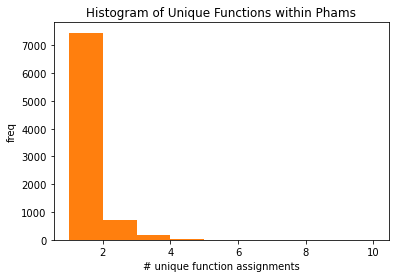

In [33]:
plt.hist(counts, bins = [1,2,3,4,5,6,7,8,9,10])
plt.hist(counts, bins = [1,2,3,4,5,6,7,8,9,10])
plt.title("Histogram of Unique Functions within Phams")
plt.xlabel("# unique function assignments")
plt.ylabel("freq")


plt.show()